In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
from matplotlib import lines
import seaborn as sns
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from bayesian_fit import *
from q_fit import *
from q_pred import * 

import multiprocessing as mp
import time


import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# loss functions
def BCE_loss(y_hat,y_true):
    eps = 1e-10
    return (-((y_true*(np.log(y_hat + eps)) + (1-y_true)*(np.log(1-y_hat + eps)))))

def MSE_loss(y_true,y_hat):
    return ((y_hat - y_true)**2).mean()

In [28]:
# read test data 
df = pd.read_csv('../data/artificial_testset_alphastat_03_probchange.csv')

num_of_agent = df['agent'].nunique() 
num_of_action = df['action'].nunique()
num_of_trials = df['trial'].nunique()

all_data = []

for i in range(num_of_agent):
    cur_df = df[(df['agent']==i)].reset_index()
    all_data.append(cur_df)

In [29]:
# fit q-stationary

all_p_1_qs = []
bce_arr_qs = []
auc_arr_qs = []
p_r2_arr_qs = []
norm_ll_arr_qs = []

alpha_qs, beta_qs = [],[]
mse_alpha_qs, mse_beta_qs = [],[]

for i in range(num_of_agent):
    
    pool = mp.Pool(processes=mp.cpu_count())
    fit_arr = pool.map(q_fit,[all_data[i],all_data[i],all_data[i],all_data[i],all_data[i]])
    pool.close()
    x = np.array([fit_arr[j].fun for j in range(5)])
    res = fit_arr[np.argmin(x)]
    if i==25:
        alpha_25_qs = np.repeat(res.x[0], num_of_trials)
        beta_25_qs = np.repeat(res.x[1], num_of_trials)
    
    auc,p_1 = q_pred(all_data[i],res.x)
    
    all_p_1_qs.append(p_1)
    alpha_qs.append(res.x[0])
    beta_qs.append(res.x[1])
    auc_arr_qs.append(auc)
    
    loss = BCE_loss(p_1, all_data[i].action.values)
    bce_arr_qs.append(loss.mean())
    p_r2_arr_qs.append( 1 - (np.array(loss.sum()) / (-len(all_data[i])*np.log(0.5))))
    norm_ll_arr_qs.append(np.exp(-loss.mean()))
    
    mse_alpha_qs.append((MSE_loss(all_data[i]['alpha']    , np.repeat(alpha_qs[i]   ,num_of_trials) ) ))
    mse_beta_qs.append((MSE_loss(all_data[i]['beta']/10  ,  np.repeat(beta_qs[i]/10 ,num_of_trials) ) ))
    
print('QS BCE '       , np.array(bce_arr_qs).mean()   )
print('QS AUC '       , np.array(auc_arr_qs).mean()   )
print('QS PR2'       , np.array(p_r2_arr_qs).mean()   )
print('QS MSE alpha ' , np.array(mse_alpha_qs).mean() )
print('QS MSE beta '  , np.array(mse_beta_qs).mean()  )

print('===================')

print('QS BCE std '       , np.array(bce_arr_qs).std()   )
print('QS PR2 std'       , np.array(p_r2_arr_qs).std()   )
print('QS MSE alpha std ' , np.array(mse_alpha_qs).std() )
print('QS MSE beta std'  , np.array(mse_beta_qs).std()  )

QS BCE  0.4176439235881638
QS AUC  0.8434470913069286
QS PR2 0.39746718258194697
QS MSE alpha  0.019488796336416668
QS MSE beta  0.03362019955408844
QS BCE std  0.17910905010417935
QS PR2 std 0.25839973836363245
QS MSE alpha std  0.07473808272991345
QS MSE beta std 0.038112362581988926


In [30]:
# fit bayesian
w = []
for i in range(num_of_agent):
    obs = all_data[i][['action','reward']].values
    w.append(bayesian_fit(obs))

alpha_bay = [ 1 / (1 + np.exp(-w[i][0][:,2])) for i in range(num_of_agent) ]
beta_bay =  [ (np.exp(w[i][0][:,3])).clip(0,10) for i in range(num_of_agent) ]
bce_arr_bay = np.array([ (-np.log(w[i][1].mean(axis=1))).mean() for i in range(num_of_agent)])

all_p_0_bay = []

mse_alpha_bay, mse_beta_bay = [],[]

for i in range(num_of_agent):
            
    mse_alpha_bay.append((MSE_loss(all_data[i]['alpha']    , alpha_bay[i]   ) ))
    mse_beta_bay.append((MSE_loss(all_data[i]['beta']/10  , beta_bay[i]/10  ) ))
    
print('BAY BCE '       , np.array(bce_arr_bay).mean()   )

print('BAY MSE alpha ' , np.array(mse_alpha_bay).mean() )
print('BAY MSE beta '  , np.array(mse_beta_bay).mean()  )

print('===================')

print('BAY BCE std '       , np.array(bce_arr_bay).std()   )
print('BAY MSE alpha std ' , np.array(mse_alpha_bay).std() )
print('BAY MSE beta std'  , np.array(mse_beta_bay).std()  )

BAY BCE  0.41759964837104846
BAY MSE alpha  0.03580385176540614
BAY MSE beta  0.02282884096999537
BAY BCE std  0.17052268061668094
BAY MSE alpha std  0.063147152877017
BAY MSE beta std 0.014169231009092365


In [31]:
class GRU_RNN_TWO(nn.Module):
        
    def __init__(self,input_size, hidden_size, num_of_layers, num_alpha_embedding, num_beta_embedding, dropout):
        
        super(GRU_RNN_TWO, self).__init__()
        
        self.input_size = input_size
        self.num_alpha_embedding = num_alpha_embedding
        self.num_beta_embedding = num_beta_embedding        
        
        self.hidden_0 = nn.GRU(  
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=num_of_layers,
                    batch_first=True,
                    dropout=dropout
        )
    

        self.out_alpha = nn.Linear(hidden_size, num_alpha_embedding)
        self.out_beta = nn.Linear(hidden_size, num_beta_embedding)
        
        self.relu_alpha = nn.ReLU()
        self.relu_beta = nn.ReLU()

        self.reg_alpha = nn.Linear(num_alpha_embedding, 1)
        self.reg_beta = nn.Linear(num_beta_embedding, 1)

        
    def forward(self, x):

        # parameters estimation
        output_0, hn_0 = self.hidden_0(x)
        
        output_alpha = self.out_alpha(output_0)
        output_alpha = self.relu_alpha(output_alpha)
        
        output_beta = self.out_beta(output_0)
        output_beta = self.relu_beta(output_beta)
        
        cont_output_alpha = self.reg_alpha(output_alpha)
        cont_output_beta = self.reg_beta(output_beta)
        
        output_dis = [output_alpha, output_beta]
        output_cont = [cont_output_alpha, cont_output_beta]

        return output_dis, output_cont, hn_0
    

class behavior_dataset(Dataset):
    """ 
    Transform Dataframe of an agent to torch Dataset class 
    
    Args:
        dataframe: pandas dataframe of agent behavior 
        n_parameters_embedding: number of parameters embedding class
        
    Returns: 
        torch Dataset:
        x: [reward_(t-1) , action_(t-1)] action are encoded as one-hot vectors
        y: [action_t, parameter embedding] action and parameters are encoded as one-hot vectors
        
    """
    def __init__(self,dataframe):
        
        # action one hot transformation 
        action = np.array(dataframe['action'])
        if np.all(action == action[0]):
            action = np.append(action,(1-action[0]))
            action = torch.tensor((action).reshape(len(dataframe) + 1),dtype=int)
            action_onehot = nn.functional.one_hot(action, len(action.unique()))
            # delete last one
            action_onehot = action_onehot[:-1]
        else:
            action = torch.tensor((action).reshape(len(dataframe)),dtype=int)
            action_onehot = nn.functional.one_hot(action, len(action.unique()))
        
        # reward
        reward = torch.tensor((np.array(dataframe['reward'])).reshape(len(dataframe)),dtype=int)
        
        # concatinating reward and action
        reward_action = torch.cat([reward[ :, np.newaxis], action_onehot],1)
        
        # adding dummy zeros to the beginning and ignoring the last one
        reward_action_shift = nn.functional.pad(reward_action,[0,0,1,0])[:-1]
        
        # network input 
        x = reward_action_shift
        
        n_blocks = int(len(dataframe)/100)
        x.reshape(n_blocks,100,3)[:,0,:] = torch.zeros(size=(n_blocks,3))
    
        y = action_onehot
  
        self.x = x.type(dtype=torch.float32)
        self.y = y.type(dtype=torch.float32)
        self.len = len(dataframe)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len    
    
class merge_behavior_dataset(Dataset):
    """ 
    Merge Dataset of each agent to one dataset
    
    Args:
        dataset_list: list of Dataset of all agent 
        n_trials: num_of_trials each agent was simulated
        
    Returns: 
        torch Dataset:
        x: [reward_(t-1) , action_(t-1)] all agents
        y: [action_t, parameter embedding] all agents
        
    """
    def __init__(self, dataset_list, n_trials):
        X = []
        Y = []
        for j,agent in enumerate(dataset_list):
            for i in range(n_trials[j]):
                X.append(agent[i][0])
                Y.append(agent[i][1])
                
        self.x = torch.stack(X).type(dtype=torch.float32)
        self.y = torch.stack(Y).type(dtype=torch.float32)
        self.len = len(X)   
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len
    
all_data_rnn = []

for i in range(num_of_agent):
    cur_df = all_data[i]
    cur_df = cur_df.reset_index()
    all_data_rnn.append(behavior_dataset(cur_df))
    
val_dataset = merge_behavior_dataset(all_data_rnn, np.repeat(num_of_trials,num_of_agent))

load = torch.load(f'checkpoint/checkpoint_trnn_val_alphastat_03_probchange.pth',map_location='cpu')

INPUT_SIZE = 3
aHidden = 32
num_alpha_embedding = 5
num_beta_embedding = 5

rnn = GRU_RNN_TWO(
              input_size=INPUT_SIZE,
              hidden_size=aHidden,
              num_of_layers=1,
              num_alpha_embedding=num_alpha_embedding,
              num_beta_embedding=num_beta_embedding,
              dropout=0
            )

rnn.load_state_dict(load['model_state'])
print(load['epoch'])
rnn.eval()

48


GRU_RNN_TWO(
  (hidden_0): GRU(3, 32, batch_first=True)
  (out_alpha): Linear(in_features=32, out_features=5, bias=True)
  (out_beta): Linear(in_features=32, out_features=5, bias=True)
  (relu_alpha): ReLU()
  (relu_beta): ReLU()
  (reg_alpha): Linear(in_features=5, out_features=1, bias=True)
  (reg_beta): Linear(in_features=5, out_features=1, bias=True)
)

In [32]:
# Maya - Calculate action predictions
# NOTE: Chosen actions should indicate the action number - when using 2-armed we could simply
# take the column of action 1 (the number that appears there is the number of the chosen
# action), but to generalize the code we could write a function that would translate the
# one-hot actions into numbers or use the dataframe.
def predict_action(y_hat_cont, rewards, chosen_actions, num_of_trials, num_of_actions):
    alphas = y_hat_cont[0]
    betas = y_hat_cont[1]

    action_predictions = torch.tensor(np.zeros((num_of_trials, num_of_actions)), device=device)

    qvals = torch.tensor(np.zeros((num_of_trials, num_of_actions)), device=device)
    for i in range(num_of_trials-1):
        prediction_error = rewards[i] - qvals[i, chosen_actions[i]]
        qvals[i+1, chosen_actions[i]] = qvals[i, chosen_actions[i]] + \
            alphas[i] * prediction_error # Q-value update
        
        action_predictions[i] = F.softmax(betas[i+1]*qvals[i+1], dim=-1) # Softmax to compute action probabilities
    
    return action_predictions.type(torch.float32)

In [33]:
def trnn_pred(df, parameters):
    # initialize predictions array
    num_of_trials = len(df)
    choice_epred = np.zeros(num_of_trials)

    # upload data of the subject/agent
    action_list = df['action'].astype(int)
    reward_list = df['reward'].astype(np.float32)
    
    # initialize q-values
    q = np.zeros(2)

    for t in range(num_of_trials):
            
        if t%100 == 0:
            q = np.zeros(2)
        
        # set up data
        choice = action_list[t]
        reward = reward_list[t]

        # set up paramters of the agent     
        alpha = parameters[0][t]
        beta = parameters[1][t]

        # decision
        p = np.exp( beta*q ) / np.sum( np.exp( beta * q ) )  
        choice_epred[t] = p[1]

        # value update
        prediction_error = reward - q[choice] 
        q[choice] = q[choice] + alpha*prediction_error 

    # auc computation
    auc = roc_auc_score(action_list, choice_epred)
           
    return auc, choice_epred

In [34]:
alpha_trnn = []
beta_trnn = []
all_p_1_trnn = []
auc_trnn = []

j = 0

for i in range(num_of_agent):
    
    cur_df = all_data[i]

    num_of_trials = len(cur_df)

    X = val_dataset[j:num_of_trials+j][0].reshape(1,num_of_trials,3)
    y_hat_dis, y_hat_cont, _ = rnn(X)

    # Maya - Add y_hat_action calculation
    param_est = [v.view(-1).cpu().detach().numpy() for v in y_hat_cont]
    auc, y_hat_action = trnn_pred(cur_df, param_est)

    alpha_trnn.append((y_hat_cont[0].cpu().detach().numpy().flatten()))    
    beta_trnn.append((y_hat_cont[1].cpu().detach().numpy().flatten()))
    all_p_1_trnn.append((y_hat_action))
    auc_trnn.append((auc))

    j += num_of_trials

    if i==25:
        res_25_trnn = [alpha_trnn[i], beta_trnn[i]]
        
bce_arr_trnn = []
p_r2_arr_trnn = []
norm_ll_arr_trnn = []
mse_alpha_trnn, mse_beta_trnn = [],[]

for i in range(num_of_agent):
    bce = BCE_loss(all_p_1_trnn[i],all_data[i]['action'])
    bce_arr_trnn.append(bce.mean())
    p_r2_arr_trnn.append(1-(np.array(bce.sum()) / (-len(all_data[i])*np.log(0.5))))
    norm_ll_arr_trnn.append(np.exp(-bce.mean()))
    mse_alpha_trnn.append( ( MSE_loss(all_data[i]['alpha']   ,alpha_trnn[i]      ) ))
    mse_beta_trnn.append(  ( MSE_loss(all_data[i]['beta']/10 ,beta_trnn[i]/10   ) ))


# temp = pd.DataFrame(np.vstack((X[0,:,2],all_data[29]['action'])).T[:num_of_trials-1,:], columns=['prediction', 'action']) - Maya: for debugging, delete later

print('tRNN BCE '       , np.array(bce_arr_trnn).mean()   )
print('tRNN AUC '       , np.array(auc_trnn).mean()   )
print('tRNN PR2 '       , np.array(p_r2_arr_trnn).mean()   )
print('tRNN MSE alpha ' , np.array(mse_alpha_trnn).mean() )
print('tRNN MSE beta '  , np.array(mse_beta_trnn).mean()  )

print('===================')

print('tRNN BCE std '       , np.array(bce_arr_trnn).std()   )
print('tRNN PR2 std '       , np.array(p_r2_arr_trnn).std()   )
print('tRNN MSE alpha std ' , np.array(mse_alpha_trnn).std() )
print('tRNN MSE beta std'  , np.array(mse_beta_trnn).std()  )

tRNN BCE  0.4104398540561955
tRNN AUC  0.8503765667485621
tRNN PR2  0.4078604579699368
tRNN MSE alpha  1.020656855915566e-09
tRNN MSE beta  0.01458788665964915
tRNN BCE std  0.17746832092075698
tRNN PR2 std  0.2560326665072672
tRNN MSE alpha std  1.1330505850700524e-09
tRNN MSE beta std 0.00803721805355339


In [43]:
# Maya - check the generative model's choice prediction to be used as baseline

auc_gen = []
all_p_1_gen = []
bce_arr_gen = []

for i in range(num_of_agent):
    
    cur_df = all_data[i]
    auc, choice_epred = trnn_pred(cur_df, [cur_df['alpha'], cur_df['beta']])
    all_p_1_gen.append((choice_epred))
    auc_gen.append(auc)

    bce = BCE_loss(all_p_1_gen[i],all_data[i]['action'])
    bce_arr_gen.append(bce.mean())

    if i==25:
        res_25_gen = [cur_df['alpha'], cur_df['beta']]

print('QPS BCE %.3f'          %np.array(bce_arr_qs).mean()   )
print('tRNN BCE %.3f'        %np.array(bce_arr_trnn).mean()   )
print('generative model BCE '       , np.array(bce_arr_gen).mean()   )

print('=============================')

print('QS AUC '       , np.array(auc_arr_qs[10:20]).mean()   )
print('tRNN AUC '       , np.array(auc_trnn[10:20]).mean()   )
print('generative model AUC '       , np.array(auc_gen[10:20]).mean()   )

# ההבדל במדד הכי בולט באברפטלי צ'יינג'ינג - כנראה כי שם השינויים הכי גדולים ואז עם אלפא ובטא קבועים יותר קשה לדרג את התצפיות נכון
# אם נגדיל את הדריפט רייט ברנדום ווק מאמינה שהפער יגדל עוד יותר, צריך לקחת בחשבון שגם כשהאלפא והבטא בפועל באמת קבועים אז הקיו-לרנינג הכי טוב מביניהם וזה משפיע על הממוצע של המדד

pd.DataFrame(np.vstack((np.array(auc_arr_qs), np.array(auc_trnn), np.array(auc_gen))).T, columns=['QS AUC', 'tRNN AUC', 'generative AUC'])

# pd.DataFrame(np.vstack((np.array(alpha_25_qs), np.array(beta_25_qs), np.array(all_p_1_qs[25]), np.array(res_25_trnn), np.array(all_p_1_trnn[25]), np.array(res_25_gen), np.array(all_data[25]['action']), np.array(all_data[25]['reward']), np.array(all_p_1_gen[25]))).T, columns=['alpha QS', 'beta QS', 'QS', 'alpha tRNN', 'beta tRNN', 'tRNN', 'true alpha', 'true beta', 'action', 'reward', 'generative']).head(50)


QPS BCE 0.418
tRNN BCE 0.410
generative model BCE  0.4015927774572342
QS AUC  0.8388912276483991
tRNN AUC  0.8587478612988722
generative model AUC  0.8622403954249647


,QS AUC,tRNN AUC,generative AUC
0,0.980884,0.980545,0.980622
1,0.914574,0.911320,0.913881
2,0.562238,0.557016,0.560240
3,0.994746,0.994553,0.994767
4,0.943817,0.941980,0.943536
5,0.988503,0.987567,0.988034
6,0.919496,0.916627,0.919166
7,0.580907,0.567471,0.569134
8,0.881151,0.877274,0.881091
9,0.894297,0.893634,0.893876


QPS BCE 0.418
QPS MSE alpha 0.019
QPS MSE beta 0.034
BAY BCE 0.418
BAY MSE alpha 0.036
BAY MSE beta 0.023
tRNN BCE 0.410
tRNN MSE alpha 0.000
tRNN MSE beta 0.015


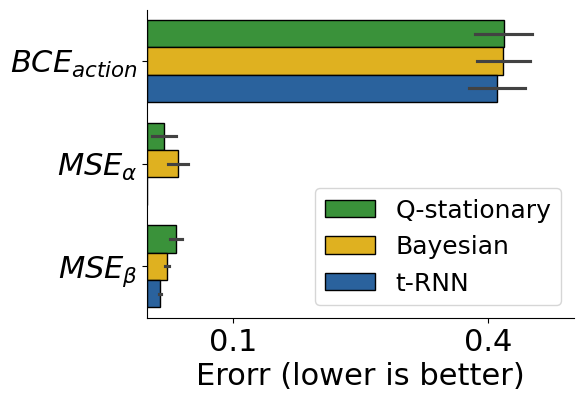

In [36]:
print('QPS BCE %.3f'          %np.array(bce_arr_qs).mean()   )
print('QPS MSE alpha %.3f'    %np.array(mse_alpha_qs).mean() )
print('QPS MSE beta %.3f'     %np.array(mse_beta_qs).mean()  )

print('=============================')

print('BAY BCE %.3f'        %np.array(bce_arr_bay).mean()   )
print('BAY MSE alpha %.3f'  %np.array(mse_alpha_bay).mean() )
print('BAY MSE beta %.3f'   %np.array(mse_beta_bay).mean()  )

print('=============================')

print('tRNN BCE %.3f'        %np.array(bce_arr_trnn).mean()   )
print('tRNN MSE alpha %.3f'  %np.array(mse_alpha_trnn).mean() )
print('tRNN MSE beta %.3f'   %np.array(mse_beta_trnn).mean()  )


all_res = pd.DataFrame({'Measurements':np.concatenate([
                    np.array(bce_arr_qs),np.array(mse_alpha_qs),np.array(mse_beta_qs),
                    np.array(bce_arr_bay),np.array(mse_alpha_bay),np.array(mse_beta_bay),
                    np.array(bce_arr_trnn),np.array(mse_alpha_trnn),np.array(mse_beta_trnn)]),
           
              'Model':
                    np.repeat(['Q-stationary','Bayesian','t-RNN'],3*num_of_agent),
              
              'Type':
#                     np.tile(np.repeat([r'$BCE\/\/\/$'+'\n action',r'$MSE_{\alpha}$',r'$MSE_{\beta}$'],num_of_agent),3)
                      np.tile(np.repeat([r'$BCE_{action}$',r'$MSE_{\alpha}$',r'$MSE_{\beta}$'],num_of_agent),3)
             })

plt.figure(figsize=(5.5,4))
sns.barplot(data=all_res,
            y='Type',x='Measurements',hue='Model',
            palette=['tab:green','#ffc100','#1761B0'],
            edgecolor='k',
            errorbar="se",
            orient='h'
           )

# plt.grid(alpha=0.5,axis='x')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('Erorr (lower is better)',size=22)
plt.ylabel('',size=0)
plt.xlim(0,0.5)
plt.xticks([0.1,0.4])
plt.legend(fontsize=18)
sns.despine()
# plt.savefig('../plots/fig_2A_H.pdf',bbox_inches='tight')
plt.show()

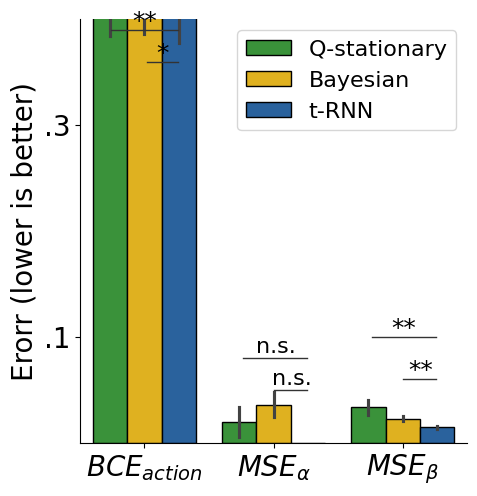

In [37]:
fig,ax1 = plt.subplots(1,1,figsize=(5,5.5))
sns.barplot(ax=ax1,data=all_res,
            x='Type',y='Measurements',hue='Model',
            palette=['tab:green','#ffc100','#1761B0'],
            edgecolor='k',
            errorbar="se",
            orient='v'
           )

# plt.grid(alpha=0.5,axis='both')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel('Erorr (lower is better)',size=20)
ax1.set_xlabel('',size=0)
ax1.set_ylim(0,0.4)
ax1.set_yticks([0.1,0.3])
ax1.legend(fontsize=16)
ax1.set_yticklabels([str(x)[1:] for x in np.round(ax1.get_yticks(), 3)])


ylim = ax1.get_ylim()
yrange = ylim[1] - ylim[0]

h = 0.02*0

line = lines.Line2D([-.26,-.26,0.26,0.26], [.39,.39+h,.39+h,.39], lw=1, c='0.2', transform=ax1.transData)
line.set_clip_on(False)
ax1.add_line(line)
ax1.annotate('**', xy=(np.mean([-.26, 0.26]),.385),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=18, clip_on=False, annotation_clip=False)

line = lines.Line2D([0.02,0.02,0.26,0.26], [.36,.36+h,.36+h,.36], lw=1, c='0.2', transform=ax1.transData)
line.set_clip_on(False)
ax1.add_line(line)
ax1.annotate('*', xy=(np.mean([0.02, 0.26]),.355),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=18, clip_on=False, annotation_clip=False)


#########

line = lines.Line2D([1,1,1.26,1.26], [.05,.05+h,.05+h,.05], lw=1, c='0.2', transform=ax1.transData)
line.set_clip_on(False)
ax1.add_line(line)
ax1.annotate('n.s.', xy=(np.mean([1.02, 1.26]),.05),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)


line = lines.Line2D([0.76,0.76,1.26,1.26], [.08,.08+h,.08+h,.08], lw=1, c='0.2', transform=ax1.transData)
line.set_clip_on(False)
ax1.add_line(line)
ax1.annotate('n.s.', xy=(np.mean([0.78, 1.26]),.08),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)

#######

line = lines.Line2D([1.76,1.76,2.26,2.26], [.1,.1+h,.1+h,.1], lw=1, c='0.2', transform=ax1.transData)
line.set_clip_on(False)
ax1.add_line(line)
ax1.annotate('**', xy=(np.mean([1.76, 2.26]),.095),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=18, clip_on=False, annotation_clip=False)


line = lines.Line2D([2,2,2.26,2.26], [.06,.06+h,.06+h,.06], lw=1, c='0.2', transform=ax1.transData)
line.set_clip_on(False)
ax1.add_line(line)
ax1.annotate('**', xy=(np.mean([2.01, 2.26]),.055),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=18, clip_on=False, annotation_clip=False)


sns.despine()
plt.savefig('../plots/fig_2A_V.pdf',bbox_inches='tight')
plt.show()


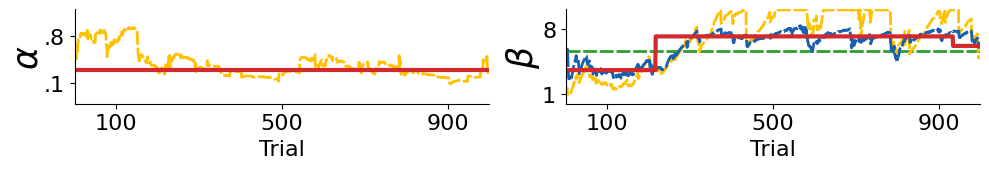

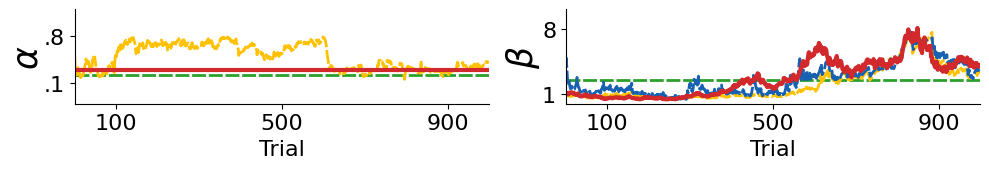

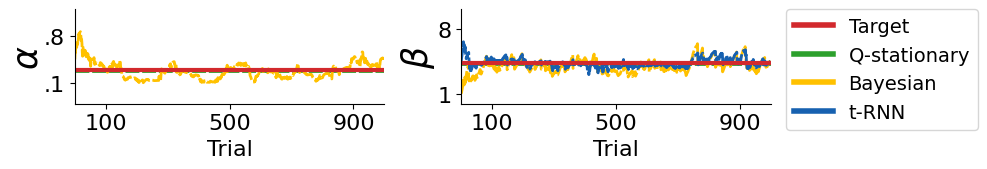

In [38]:
pla = ['#D2292D','tab:green','#ffc100','#1761B0']

for i in [15,22,8]: # range(num_of_agent): 
    
    cur = all_data[i]
    
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,1.8))
        
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=np.repeat(alpha_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_bay[i],color=pla[2],lw=2,ls=(0, (5, 1)))# bay
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=cur.alpha,color=pla[0],lw=3) # target
        

    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=np.repeat(beta_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_bay[i],color=pla[2],lw=2,ls=(0, (5, 1))) # bay
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=cur.beta,color=pla[0],lw=3)
    
    ax0.set_xticklabels([])
    ax0.set_xlim(0,num_of_trials)
    ax0.set_ylim(-0.2,1.2)
    ax0.set_ylabel(r'$\alpha$',size=25,labelpad=0)
    ax0.set_yticks([.1,.8])
    ax0.set_yticklabels([.1,0.8],size=16)
    ax0.set_yticklabels([str(x)[1:] for x in np.round(ax0.get_yticks(), 3)])
    
    ax1.set_xlim(0,num_of_trials)
    ax1.set_ylim(-0.1,10.1)
    ax1.set_ylabel(r'$\beta$',size=25,labelpad=0)
    ax1.set_yticks([1,8])
    ax1.set_yticklabels([1,8],size=16)
    ax1.set_xlabel('Trial',size=16)
    
    ax0.set_xlim(0,1000)
    ax0.set_xticks([100,500,900])
    ax0.set_xticklabels([100,500,900],size=16)
    ax0.set_xlabel('Trial',size=16)
    
    ax1.set_xlim(0,1000)
    ax1.set_xticks([100,500,900])
    ax1.set_xticklabels([100,500,900],size=16)
    

    legend_elements = [Line2D([0],[0] ,lw=4, color=pla[0], label='Target'),
                       Line2D([0],[0] ,lw=4, color=pla[1], label='Q-stationary'),
                       Line2D([0],[0] ,lw=4, color=pla[2], label='Bayesian'),
                       Line2D([0],[0] ,lw=4, color=pla[3], label='t-RNN'),
                      ]

    if i == 8:
        ax1.legend(handles=legend_elements,bbox_to_anchor=(1.05, 1),ncol=1,loc='upper left', borderaxespad=0.,
                  fontsize=14)

    sns.despine()
    plt.tight_layout()
    plt.savefig(f'../plots/fig_2B_{i}.pdf')
    plt.show()
        

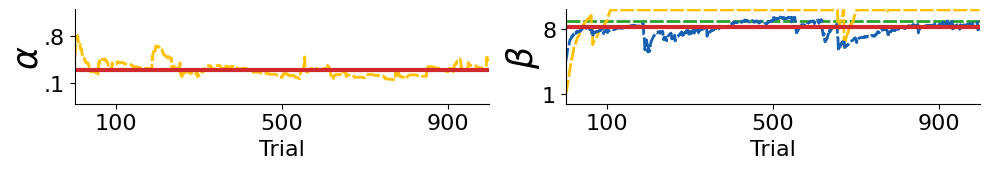

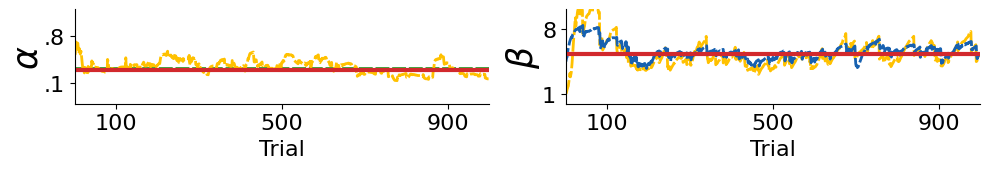

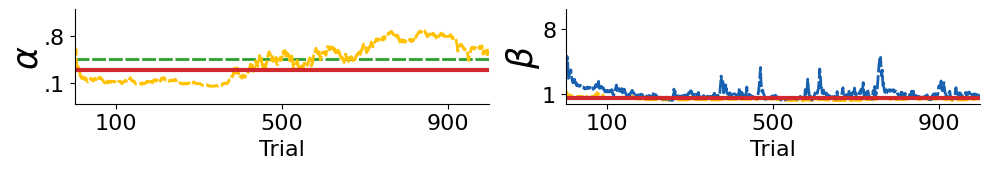

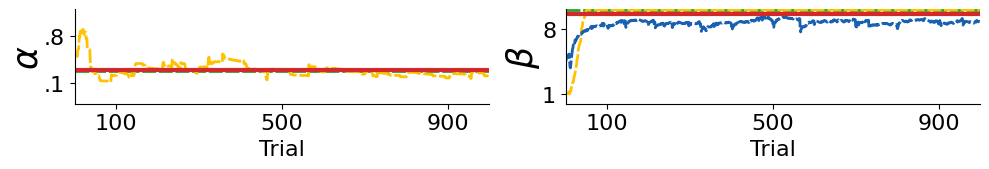

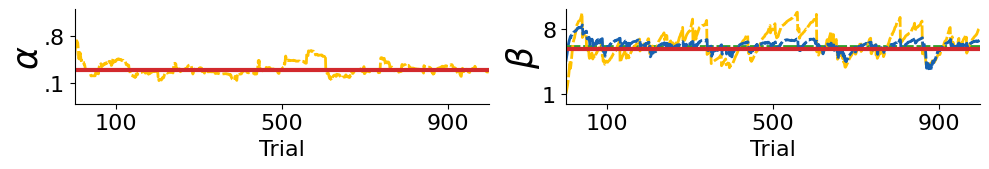

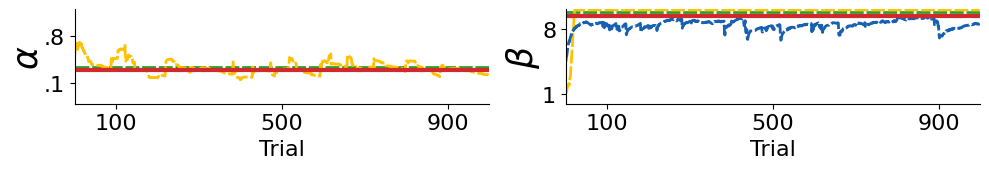

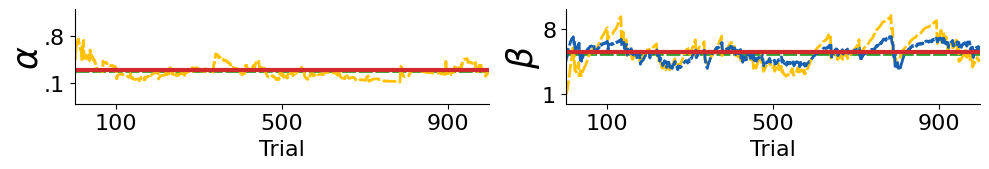

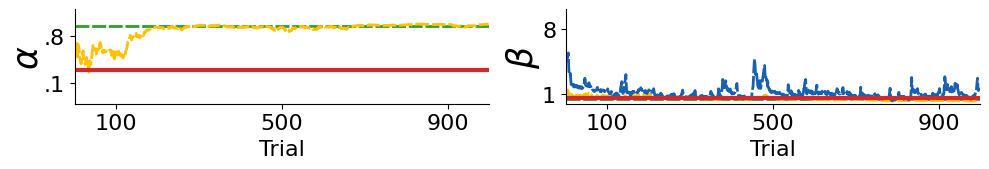

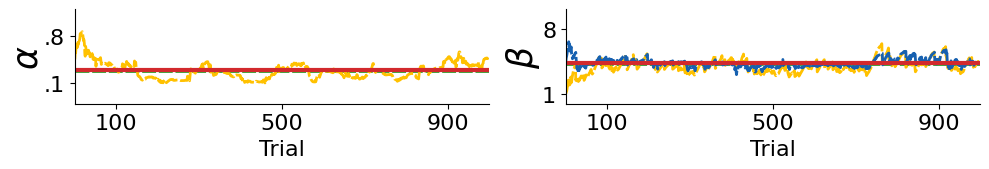

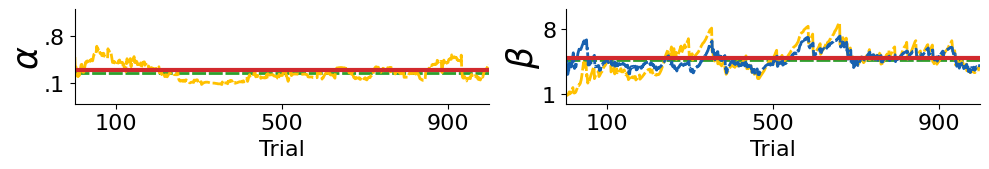

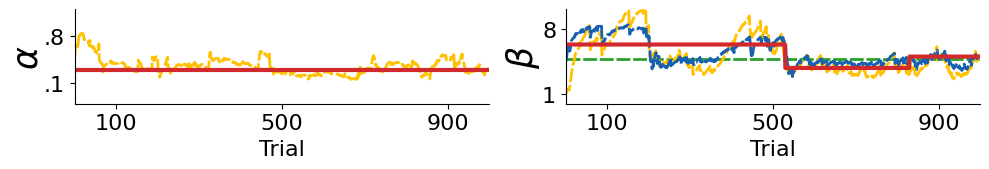

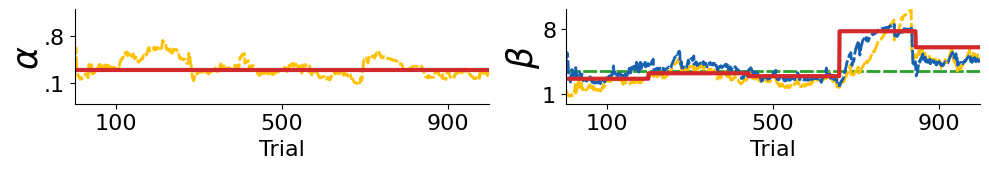

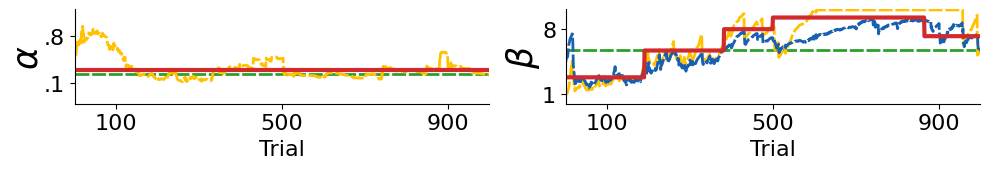

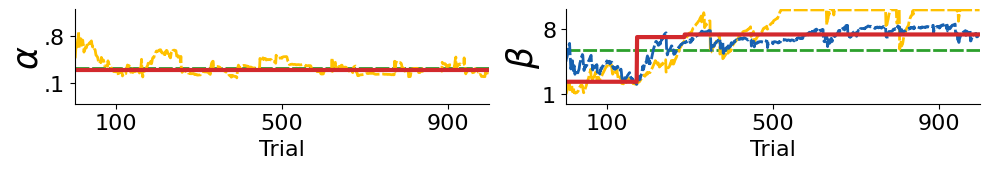

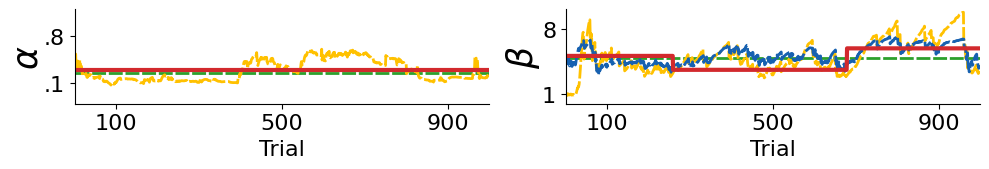

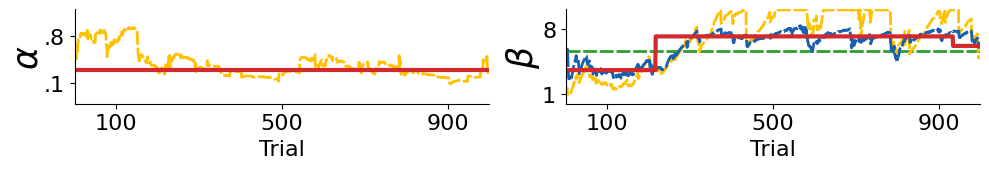

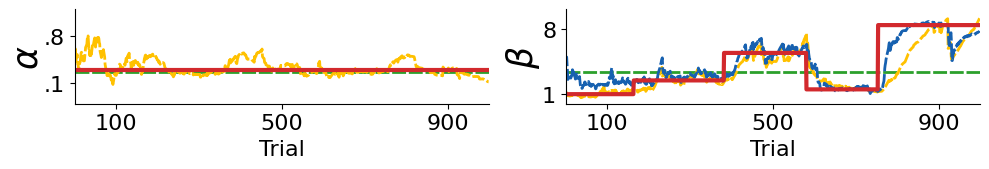

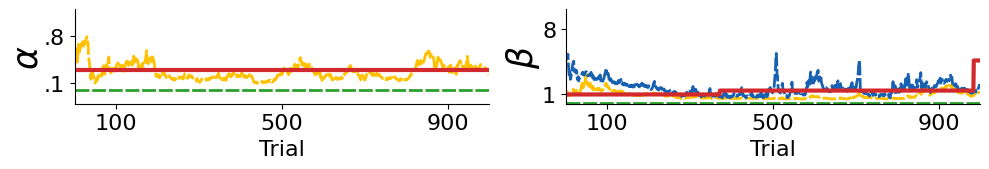

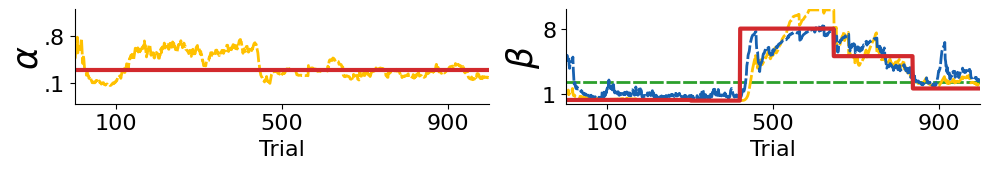

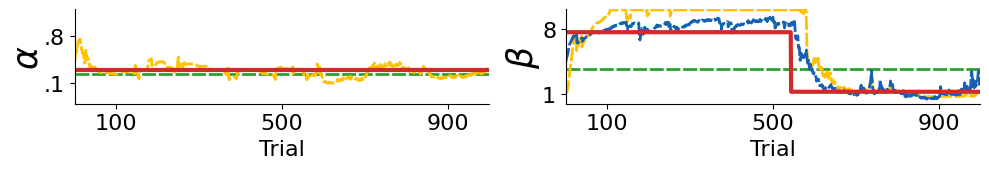

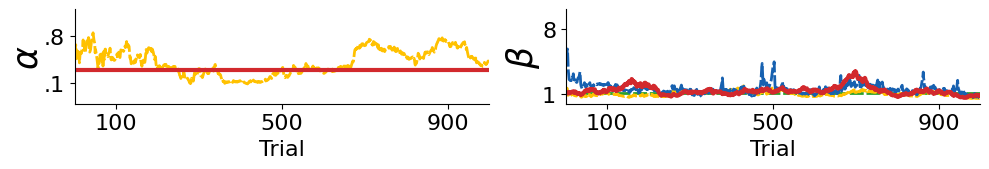

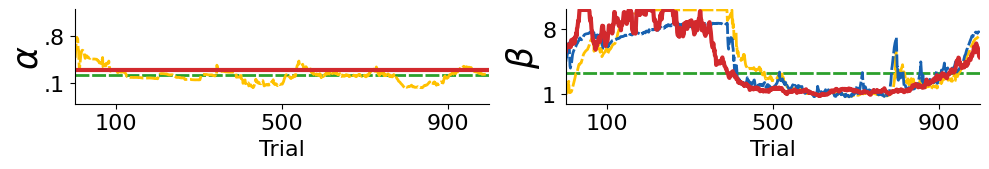

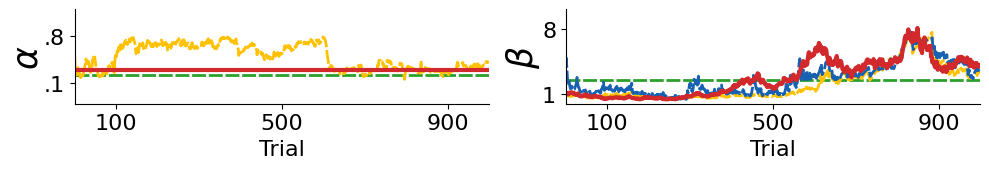

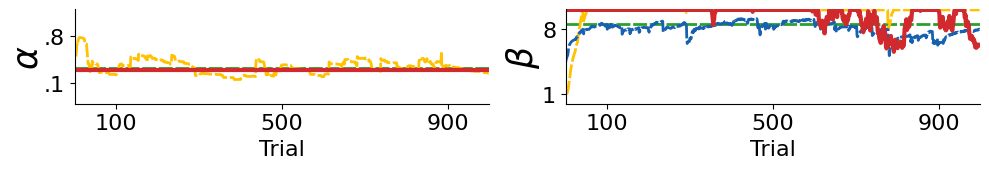

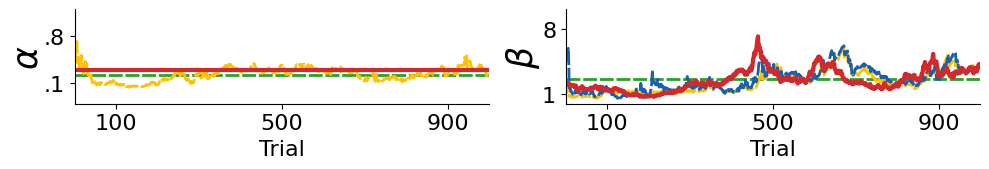

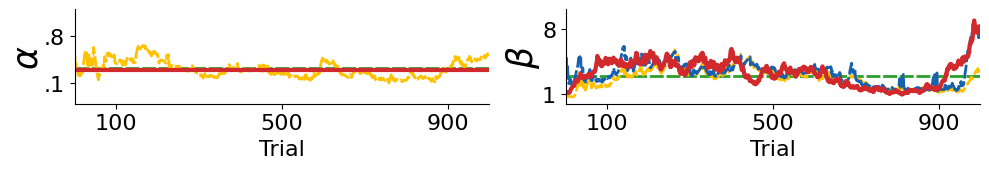

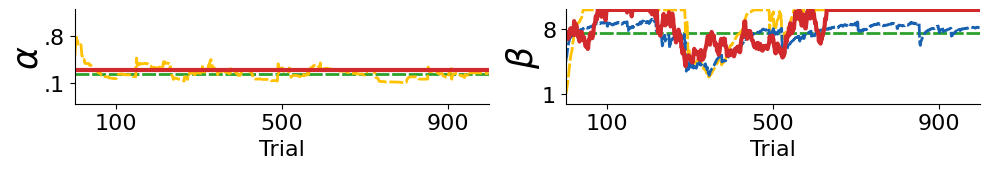

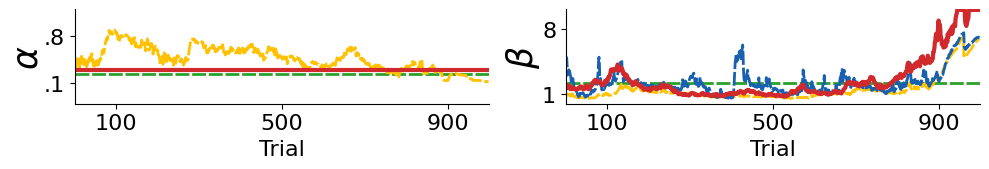

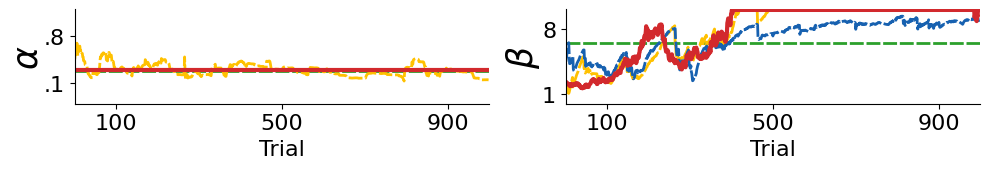

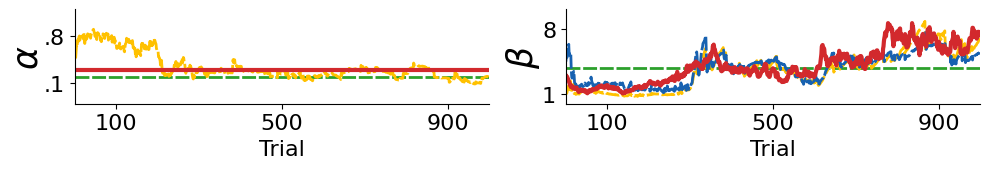

In [39]:
pla = ['#D2292D','tab:green','#ffc100','#1761B0']

for i in range(num_of_agent): 
    
    cur = all_data[i]
    
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,1.8))
        
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=np.repeat(alpha_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_bay[i],color=pla[2],lw=2,ls=(0, (5, 1)))# bay
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=cur.alpha,color=pla[0],lw=3) # target
        

    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=np.repeat(beta_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_bay[i],color=pla[2],lw=2,ls=(0, (5, 1))) # bay
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=cur.beta,color=pla[0],lw=3)
    
    ax0.set_xticklabels([])
    ax0.set_xlim(0,num_of_trials)
    ax0.set_ylim(-0.2,1.2)
    ax0.set_ylabel(r'$\alpha$',size=25,labelpad=0)
    ax0.set_yticks([.1,.8])
    ax0.set_yticklabels([.1,0.8],size=16)
    ax0.set_yticklabels([str(x)[1:] for x in np.round(ax0.get_yticks(), 3)])
    
    ax1.set_xlim(0,num_of_trials)
    ax1.set_ylim(-0.1,10.1)
    ax1.set_ylabel(r'$\beta$',size=25,labelpad=0)
    ax1.set_yticks([1,8])
    ax1.set_yticklabels([1,8],size=16)
    ax1.set_xlabel('Trial',size=16)
    
    ax0.set_xlim(0,1000)
    ax0.set_xticks([100,500,900])
    ax0.set_xticklabels([100,500,900],size=16)
    ax0.set_xlabel('Trial',size=16)
    
    ax1.set_xlim(0,1000)
    ax1.set_xticks([100,500,900])
    ax1.set_xticklabels([100,500,900],size=16)
    

    sns.despine()
    plt.tight_layout()

    plt.show()
        

